# Visualize results

In [1]:
import geopandas as gpd
import pandas as pd
import shapely
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import preprocess_data
from matplotlib import gridspec

Retrieve list of layers of relevant boundaries

In [2]:
boundary_list = list(gpd.list_layers("/data/uscuni-boundaries/impact_boundaries.gpkg").name)

Get area of interest (Central Europe sans Hungary)

In [3]:
aoi = gpd.read_file("/data/uscuni-boundaries/impact_boundaries.gpkg", layer="1994_political")
aoi = aoi.dissolve()

Define functions for visualization (diagrams)

In [4]:
def generate_boundary_diagram(boundary_name, level="level_7", ax=False, width_multiplier=4, cmap='plasma'):
    """Generates a boundary diagram of a given layer."""
    boundary = gpd.read_file("/data/uscuni-boundaries/impact_boundaries.gpkg", layer=boundary_name)

    #Retrieve level-7 BC matrix for layer of interest
    bray_curtis_matrix = pd.read_parquet(f'/data/uscuni-boundaries/bc_matrices/bc_{boundary_name}_{level}.pq')

    #Segment boundaries between adjacent regions
    indices = boundary.sindex.query(boundary.geometry, predicate="intersects")
    left, right = np.unique(np.sort(indices, axis=0), axis=1)

    mask = left == right
    left = left[~mask]
    right = right[~mask]
    geoms = boundary.iloc[left].intersection(boundary.iloc[right], align=False)
    left = boundary.NAME.iloc[left]
    right = boundary.NAME.iloc[right]

    #Retrieve BC dissimilarity values between every two adjacent regions
    border_widths = []
    for l, r in zip(left, right):
        border_widths.append(bray_curtis_matrix.loc[l, r])

    #Recalculate border widths so that higher BC dissimilarity values are emphasized
    line_widths = [(0.1 + width_multiplier*(np.exp(2*w) - 1)) for w in border_widths]

    #Create a colormap to emphasize higher BC dissimilarity values between adjacent regions
    norm=plt.Normalize(0, .7)
    # cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["lightgray","black"])
    if isinstance(cmap, str):
        cmap = matplotlib.colormaps[cmap]

    #Plotting
    if ax:
        for geom, width, border in zip (geoms, line_widths, border_widths):
            gpd.GeoSeries([shapely.line_merge(geom)]).plot(ax=ax, linewidth=width, color=cmap(norm(border)))
            ax.set_title(f"{boundary_name}")
    else:
        fig, ax = plt.subplots()
        ax.set_title(boundary_name)
        for geom, width, border in zip (geoms, line_widths, border_widths):
            gpd.GeoSeries([shapely.line_merge(geom)]).plot(ax=ax, linewidth=width, color=cmap(norm(border)))

In [5]:
def generate_boundary_diagrams(boundary_lst, level, show_aoi=False, width_multiplier=4, cmap='plasma'):
    """Generates boundary diagrams of each layer in boundary_lst based on on specified level."""
    fig, axs = plt.subplots(ncols=5, nrows=3, figsize=(9,5.5), sharex=True, sharey=True, dpi=300)
    axs = axs.flatten()
    # fig.suptitle(level)
    for i, boundary in enumerate(boundary_list):
        if show_aoi:
            aoi.plot(ax=axs[i], color='whitesmoke')
        generate_boundary_diagram(boundary, level, ax=axs[i], width_multiplier=width_multiplier, cmap=cmap)

    plt.tight_layout()

    for ax in axs:
        ax.set_axis_off()

    fig.subplots_adjust(wspace = 0.00, hspace=0.00)

    norm=plt.Normalize(0, .7)
    cmap = matplotlib.colormaps[cmap]

    bins = 50
    for i, d in enumerate(np.linspace(0, .7, bins)):
        axs[-1].plot([i, i+1], [0, 0], linewidth=(0.1 + width_multiplier*(np.exp(2*d) - 1)), color=cmap(norm(d)), solid_capstyle='butt')

    axs[5]._shared_axes['x'].remove(axs[-1])
    axs[-2]._shared_axes['y'].remove(axs[-1])
    axs[-1].text(0, -.01, 0, fontdict=dict(fontsize=6))
    axs[-1].text(bins - bins *.1, -.01, 0.7, fontdict=dict(fontsize=6))
    axs[-1].text(0, -.02, "Bray-Curtis distance", fontdict=dict(fontsize=6))
    axs[-1].set_xlim(-.3, bins * 1.3)

    return axs

Define functions for visualization (Bray-Curtis matrices)

In [6]:
def generate_bc_heatmap_for_boundary(boundary_name, level="level_7", cmap='plasma'):
    """Returns lower triangle of a BC matrix and its labels of specified layer in boundary_lst and level."""
    df = pd.read_parquet(f'/data/uscuni-boundaries/bc_matrices/bc_{boundary_name}_{level}.pq')
    
    arr_boundary = df.values
    rows, cols = arr_boundary.shape
    
    mask = np.triu(np.ones_like(arr_boundary, dtype=bool))
    heatmap = np.ma.array(arr_boundary, mask=mask)
    labels = df.columns.tolist()

    return heatmap, labels

In [7]:
def generate_bc_heatmap_for_boundaries(boundary_lst, level="level_7", cmap="plasma"):
    """Generates heatmaps of BC matrices of each layer in boundary_lst based on specified level."""
    bc_matrices = []
    label_list = []
    for boundary_name in boundary_lst:
        data, data_labels = generate_bc_heatmap_for_boundary(boundary_name, level)
        bc_matrices.append(data)
        label_list.append(data_labels)

    max_dim = max([x.shape[0] for x in bc_matrices])

    fig, axs = plt.subplots(ncols=5, nrows=3, figsize=(9,5.5), dpi=300)
    axs = axs.flatten()
    
    for i, (matrix, name) in enumerate(zip(bc_matrices, boundary_lst)):
        dim = matrix.shape[0]
        padded_matrix = np.zeros((max_dim,max_dim))
        mask = np.ones((max_dim, max_dim), dtype=bool)

        padded_matrix[max_dim - dim :, :dim] = matrix.data
        mask[max_dim - dim :, :dim] = matrix.mask

        padded = np.ma.array(padded_matrix, mask=mask)
        #padded_matrices.append(masked)
        labels = label_list[i]
        labels_x = list(labels)+[""]*(max_dim - len(labels))
        labels_y = [""] * (max_dim - len(labels)) + list(labels)
        
        ax = axs[i]
        ax.imshow(padded, cmap=cmap, vmin=0, vmax=0.7, )
        ax.set_title(name, fontsize=6, )
        ax.set_xticks(range(max_dim))
        ax.set_xticklabels(labels_x, rotation="vertical", fontsize=4)
        ax.set_yticks(range(max_dim))
        ax.set_yticklabels(labels_y, fontsize=4)
        
        ax.set_xticks(np.arange(-.5, max_dim, 1), minor=True)
        ax.set_yticks(np.arange(-.5, max_dim, 1), minor=True)

        ax.grid(which='minor', color='w', linestyle='-', linewidth=0.4)
        ax.tick_params(which='minor', bottom=False, left=False)
        ax.tick_params(length=0)

        ax.spines[:].set_visible(False)
        
        for r in range(dim):
            for c in range(dim):
                val = matrix[r, c]
                if matrix.mask[r, c]:
                    continue
                color = "black" if val > 0.55 else "white"
                ax.text(c, max_dim - dim + r, f"{val:.2f}", fontsize=3,
                        ha='center', va='center', color=color)
    fig.subplots_adjust(wspace=0.0, hspace=1.4)
    
    norm=plt.Normalize(0, .7)
    cmap = matplotlib.colormaps[cmap]

    bins = 50
    for i, d in enumerate(np.linspace(0, .7, bins)):
        axs[-1].plot([i, i+1], [0, 0], linewidth=(1.5), color=cmap(norm(d)), solid_capstyle='butt')

    axs[5]._shared_axes['x'].remove(axs[-1])
    axs[-2]._shared_axes['y'].remove(axs[-1])
    axs[-1].text(0, -.015, 0, fontdict=dict(fontsize=4))
    axs[-1].text(bins - bins *.1, -.015, 0.7, fontdict=dict(fontsize=4))
    axs[-1].text(0, -.03, "Bray-Curtis distance", fontdict=dict(fontsize=4))
    axs[-1].set_xlim(-.3, bins * 1.3) 
    for spine in axs[-1].spines.values():
        spine.set_visible(False)
    axs[-1].set_xticks([])
    axs[-1].set_yticks([])

    return axs

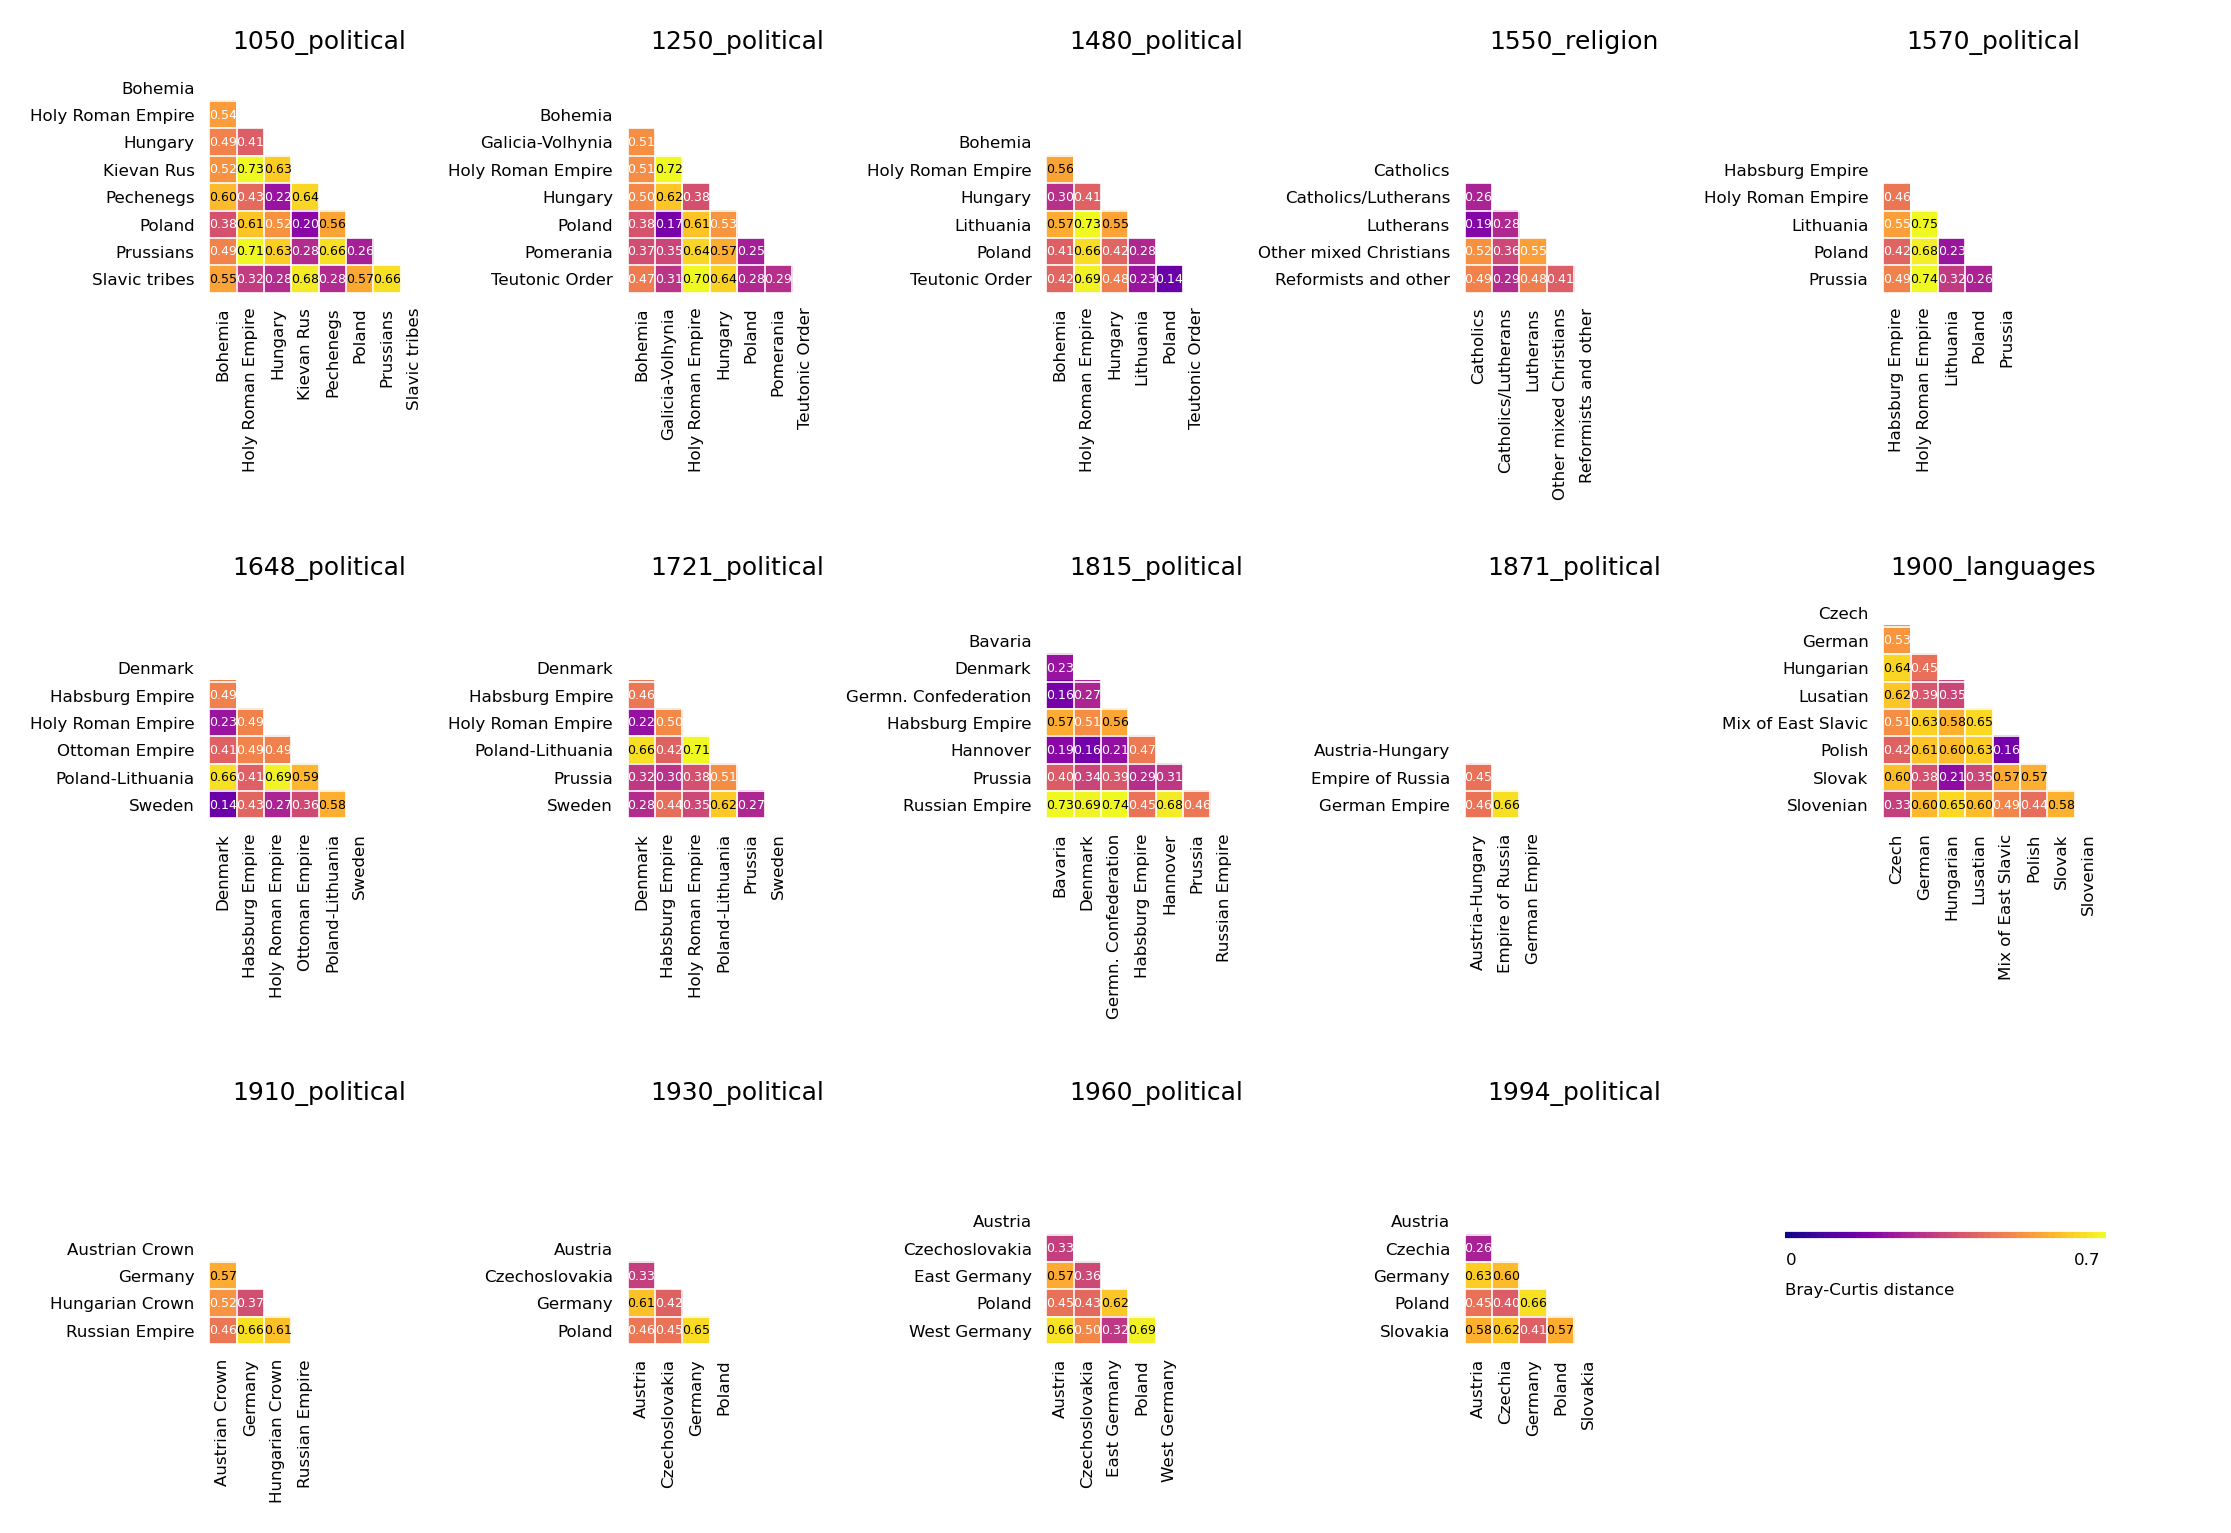

In [8]:
axs = generate_bc_heatmap_for_boundaries(boundary_list)

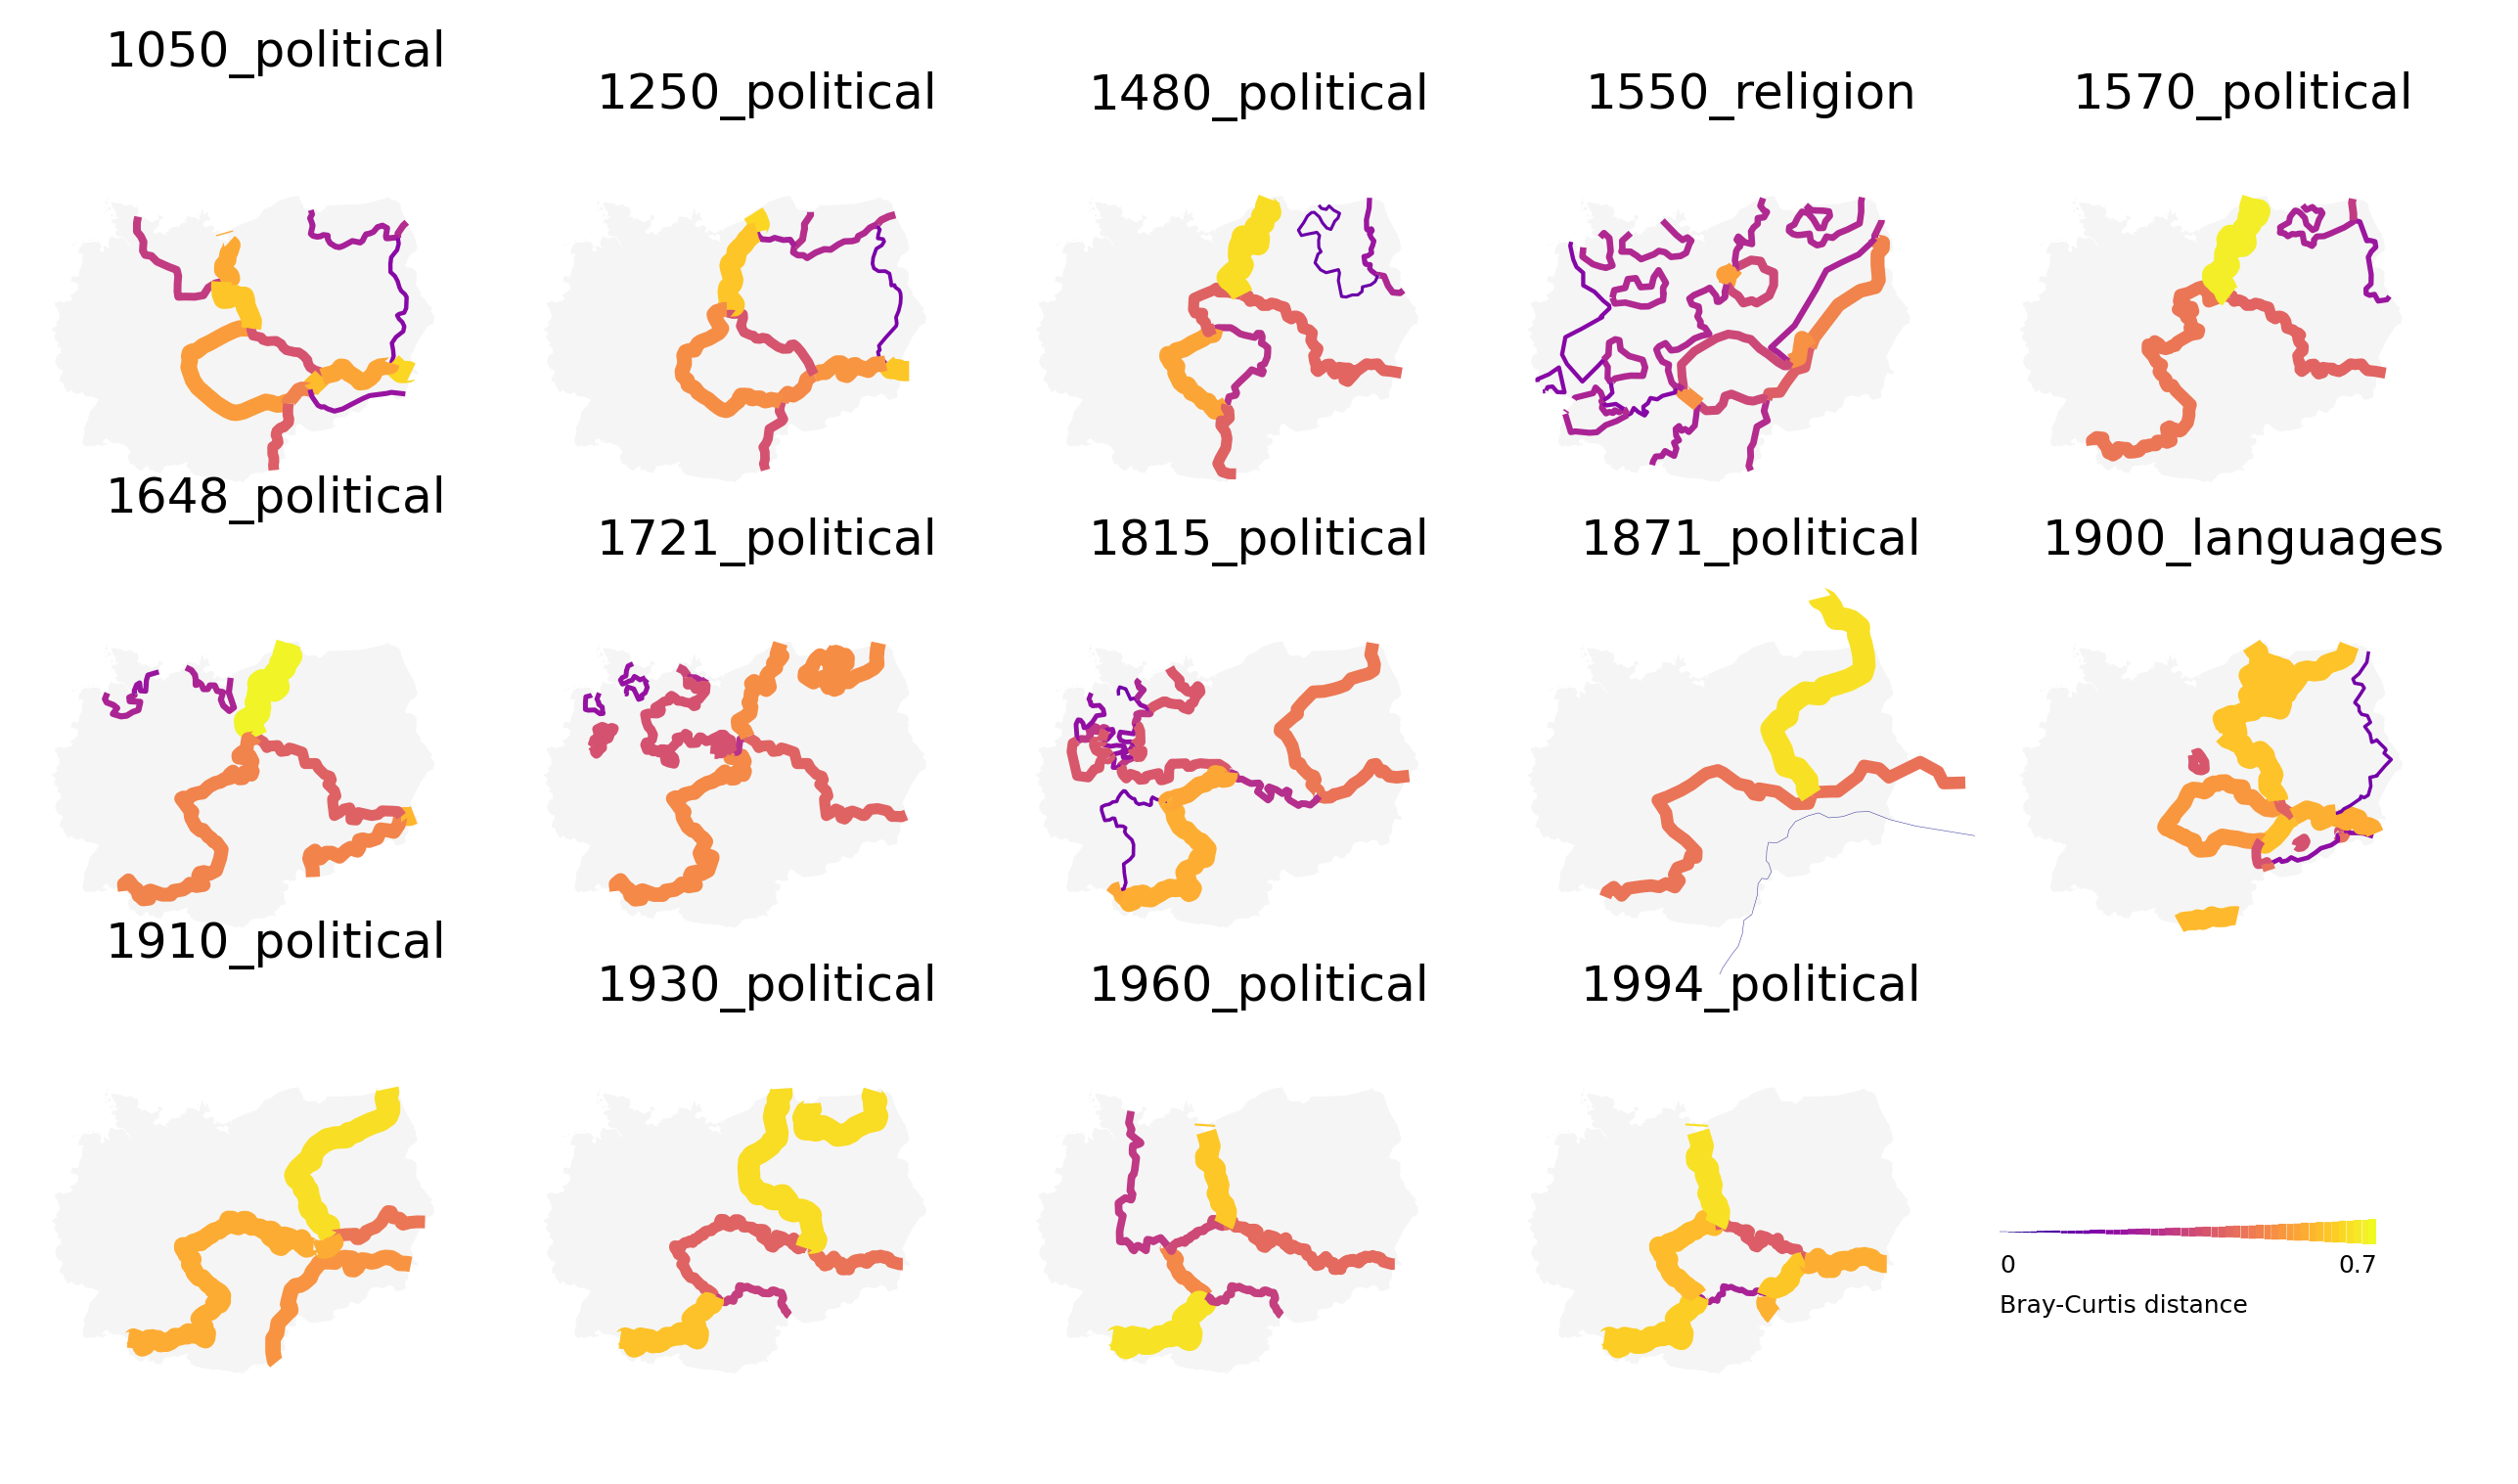

In [9]:
axs = generate_boundary_diagrams(boundary_list, "level_7", show_aoi=True, width_multiplier=2)